# How to import and use pulses from the Q-CTRL Open Controls library
**Use pulses from an open-source library in Boulder Opal calculations**

Boulder Opal enables you to perform a variety of computations using custom control solutions.  In some cases it's useful to import known analytic solutions as benchmarks.  Q-CTRL provides a comprehensive library of control techniques from the open literature that may be imported from the Open Controls package

In defining control solutions one may draw from the [Q-CTRL Open Controls](https://github.com/qctrl/open-controls) library, described in the [reference documentation](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols.html) in defining, for example, the $\Omega(t)$ driven control term frequently employed in a calculation.  

## Summary workflow

### 1. Import Open Controls
Use standard Python import functions to gain access to the Open Controls package via `qctrlopencontrols`:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
import qctrlopencontrols as oc
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

### 2. Define control objects linked to Open Controls definitions
Following import we can define driven controls using library entries from the Open Controls package.  It is often convenient to employ schemes in Python for this purpose. 

In [2]:
# Define a few selected examples of driven control schemes
schemes = {
    name: {"function": function}
    for name, function in [
        ("primitive", oc.new_primitive_control),
        ("BB1", oc.new_bb1_control),
        ("SK1", oc.new_sk1_control),
        ("CORPSE", oc.new_corpse_control),
    ]
}

### 3. Integrate control definitions into graphs

Entries from Open Controls may be integrated into a graph-based calculation through definition of the piecewise-constant (PWC) pulses for the time-dependent control $\Omega(t)$.  Simply reference the scheme element inside the graph calculation.

##  Example: Calculating the noise susceptibility of pulses from the Open Controls library.  

In this example we will compare the composite $\pi$ pulses imported from Open Controls and applied to a single qubit under amplitude and dephasing noise. The Hamiltonian of the quantum system is:

\begin{align*}
H(t) = &\frac{1+\beta(t)}{2}\Big( \Omega(t) \sigma_- + \Omega^*(t) \sigma_+ \Big) + \frac{\eta(t)}{2} \sigma_z
\end{align*}

where $\Omega(t)$ is a time-dependent Rabi rate, $\beta(t)$ is a fractional time-dependent amplitude fluctuation process, $\eta(t)$ is a small slowly-varying stochastic dephasing noise process, $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$, and $\sigma_k$ are the Pauli matrices.

Comparing the variation in infidelity across a 2D grid of $(\beta,\eta)$ gives information about the robustness of the appropriate control to simultaneous quasi-static noise on the two channels.

In [3]:
# Define control parameters
total_rotation = np.pi  # Target rotation angle here is a \pi pulse.
omega_max = 2 * np.pi * 1e6  # rad/s, this is the maximum Rabi rate in the system.

# Define coefficient arrays for the noise values.
# We use a grid with 51 points for $\beta\in [-0.5,0.5]$
# and 101 points for $\eta\in[-\Omega_{\mathrm{max}}, \Omega_{\mathrm{max}}]$.
amplitude_coefficients = np.linspace(-0.5, 0.5, 51)
dephasing_coefficients = np.linspace(-1.0, 1.0, 101) * omega_max


def calculate_quasi_static_scan(pulse):
    # Create graph
    graph = bo.Graph()

    # [51, 1, T] array with values of (1+β)Ω(t) on each segment and for each value of β
    complex_rabi_rates_with_noise = (
        (1 + amplitude_coefficients[:, None, None])
        * pulse.rabi_rates
        * np.exp(1j * pulse.azimuthal_angles)
    )
    # [51, 1] batch of PWC signals for (1+β)Ω(t)
    # We specify time_dimension=2, as the PWC values array has two batching dimensions.
    rabi_signal = graph.pwc(
        values=complex_rabi_rates_with_noise,
        durations=pulse.durations,
        time_dimension=2,
    )
    # [51, 1] batch of 2×2 PWC operators for the coupling term, (1+β)[Ω(t)σ- + Ω*(t)σ+]/2
    rabi_coupling_term = graph.hermitian_part(rabi_signal * graph.pauli_matrix("M"))

    # [1, 101] batch of 2×2 constant (with a single segment) PWC signals for η
    dephasing_signal = graph.pwc(
        values=dephasing_coefficients[None, :, None],
        durations=np.array([pulse.duration]),
        time_dimension=2,
    )
    # [1, 101] batch of 2×2 PWC operators for the dephasing drift term, η σz/2
    dephasing_term = dephasing_signal * graph.pauli_matrix("Z") / 2

    # [51, 101] batch of 2×2 PWC operators for the total Hamiltonian,
    # with each element in the batch represents a unique pair of (β, η) values
    # (the [51, 1] and [1, 101] batches get broadcasted to [51, 101]).
    hamiltonian = rabi_coupling_term + dephasing_term

    # [51, 101] tensor with the infidelities
    graph.infidelity_pwc(
        hamiltonian=hamiltonian,
        target=graph.target(graph.pauli_matrix("X")),
        name="infidelities",
    )

    # Execute the graph
    result = bo.execute_graph(graph=graph, output_node_names="infidelities")

    # Extract and return infidelities
    return result["output"]["infidelities"]["value"]

We can now call the function for each Q-CTRL Open Controls scheme and extract the calculated infidelities.
We also store the values for the noise coefficients in the quasi-static scan to plot them. For 2D scans, density plots can provide intuitive visualizations of the noise robustness. With the grid of infidelities extracted above, it is simple to create such plots using the Matplotlib library.

In [4]:
for scheme_name, scheme_objects in schemes.items():
    # Define pulse objects using pulses from Q-CTRL Open Controls
    pulse = scheme_objects["function"](
        rabi_rotation=total_rotation, azimuthal_angle=0.0, maximum_rabi_rate=omega_max
    )

    print(f"\nObtaining infidelities for {scheme_name} scheme...")

    # Create and execute the graph that calculates the infidelities
    infidelities = calculate_quasi_static_scan(pulse)

    # Save calculated infidelities
    scheme_objects["infidelities"] = infidelities

    # Save relevant quantities for later use
    scheme_objects["dephasing noise values"] = dephasing_coefficients
    scheme_objects["drive noise values"] = amplitude_coefficients


Obtaining infidelities for primitive scheme...
Your task (action_id="1828440") is queued.
Your task (action_id="1828440") has completed.

Obtaining infidelities for BB1 scheme...
Your task (action_id="1828441") has completed.

Obtaining infidelities for SK1 scheme...
Your task (action_id="1828442") has started.
Your task (action_id="1828442") has completed.

Obtaining infidelities for CORPSE scheme...
Your task (action_id="1828443") has completed.


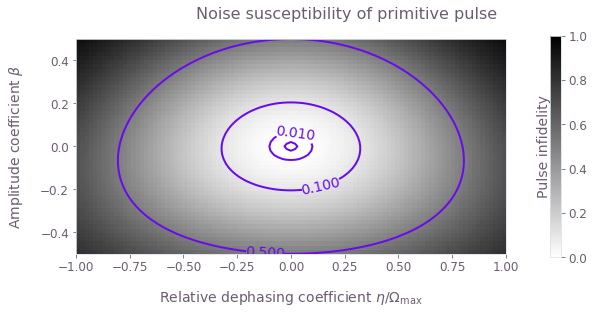

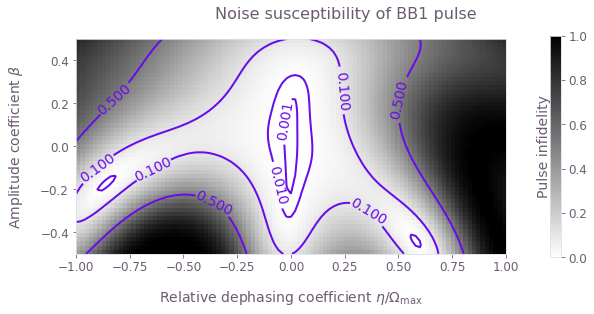

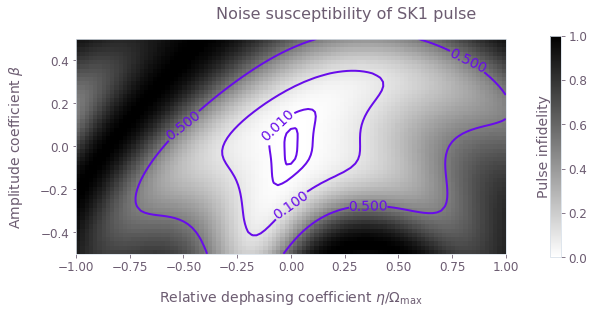

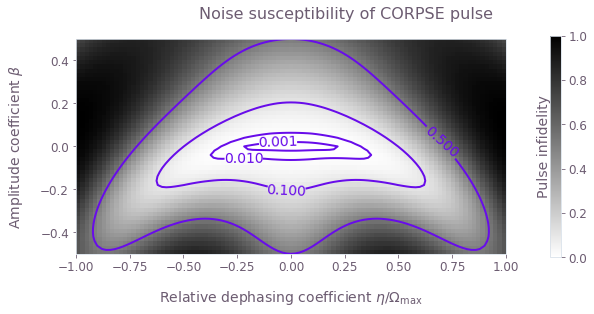

In [5]:
for scheme_name, scheme_objects in schemes.items():
    fig = plt.figure(figsize=(10, 4))

    contours = plt.contour(
        scheme_objects["dephasing noise values"] / omega_max,
        scheme_objects["drive noise values"],
        scheme_objects["infidelities"],
        levels=[0.001, 0.01, 0.1, 0.5],
        colors="#680CEA",
    )
    plt.clabel(contours, inline=True)

    plt.imshow(
        scheme_objects["infidelities"],
        extent=[
            np.min(dephasing_coefficients) / omega_max,
            np.max(dephasing_coefficients) / omega_max,
            np.min(amplitude_coefficients),
            np.max(amplitude_coefficients),
        ],
        origin="lower",
        cmap=plt.colormaps["gray"].reversed(),
        vmin=0,
        vmax=1,
    )

    cbar = plt.colorbar(pad=0.08)
    cbar.set_label("Pulse infidelity", labelpad=-50)
    fig.suptitle(f"Noise susceptibility of {scheme_name} pulse")
    plt.ylabel(r"Amplitude coefficient $\beta$")
    plt.xlabel(r"Relative dephasing coefficient $\eta/\Omega_\mathrm{max}$")
    plt.show()